In [1]:
# Internet proxy (needed in China)
import subprocess
import os
import sys

# Location to store the model checkpoint. Change into your own dir!!! The checkpoint file is approximately 22 GiB
os.environ['HF_HOME'] = '/root/autodl-tmp/cache/'
os.environ['HF_HUB_CACHE'] = '/root/autodl-tmp/cache/hub/'
os.environ['HF_DATASETS_CACHE'] = '/root/autodl-tmp/cache/datasets/'

from huggingface_hub import login
# A Hugging Face token is required to download the model checkpoint
login(token='your token')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/autodl-tmp/cache/token
Login successful


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import inspect
# Pipeline to load the full development model, quantized into FP8
from torch import Tensor
from typing import Any, Callable, Dict, List, Optional, Union
from einops import rearrange, repeat
from optimum.quanto import freeze, qfloat8, quantize
from diffusers import FlowMatchEulerDiscreteScheduler, AutoencoderKL
from diffusers.models.transformers.transformer_flux import FluxTransformer2DModel
from diffusers.pipelines.flux.pipeline_flux import FluxPipeline
from transformers import CLIPTextModel, CLIPTokenizer,T5EncoderModel, T5TokenizerFast

dtype = torch.bfloat16
bfl_repo = "black-forest-labs/FLUX.1-dev"
revision = "refs/heads/main"

def get_models():
	scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(bfl_repo, subfolder="scheduler", revision=revision)
	clip_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
	clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
	t5_encoder = T5EncoderModel.from_pretrained(bfl_repo, subfolder="text_encoder_2", torch_dtype=dtype, revision=revision)
	t5_tokenizer = T5TokenizerFast.from_pretrained(bfl_repo, subfolder="tokenizer_2", torch_dtype=dtype, revision=revision)
	vae = AutoencoderKL.from_pretrained(bfl_repo, subfolder="vae", torch_dtype=dtype, revision=revision)
	model = FluxTransformer2DModel.from_pretrained(bfl_repo, subfolder="transformer", torch_dtype=dtype, revision=revision)

	quantize(model, weights=qfloat8)
	freeze(model)

	quantize(t5_encoder, weights=qfloat8)
	freeze(t5_encoder)

	return scheduler, clip_encoder, clip_tokenizer, t5_encoder, t5_tokenizer, vae, model

In [11]:
# Remember to run this cell before initializing the classes below !!!
# This initializes the pipeline with these models

scheduler, clip_encoder, clip_tokenizer, t5_encoder, t5_tokenizer, vae, model = get_models()

pipeline = FluxPipeline(
	scheduler=scheduler,
	text_encoder=clip_encoder,
	tokenizer=clip_tokenizer,
	text_encoder_2=t5_encoder,
	tokenizer_2=t5_tokenizer,
	vae=vae,
	transformer=model,
).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

# HuggingFace Flux-dev Inference Pipeline

In [6]:
# helper functions to calculate the time distribution

def calculate_shift_hf(
	image_seq_len,
	base_seq_len: int = 256,
	max_seq_len: int = 4096,
	base_shift: float = 0.5,
	max_shift: float = 1.15,
):
	print(f"image_seq_len: {image_seq_len}, base_seq_len: {base_seq_len}, max_seq_len: {max_seq_len}, base_shift: {base_shift}, max_shift: {max_shift}")
	m = (max_shift - base_shift) / (max_seq_len - base_seq_len)
	b = base_shift - m * base_seq_len
	mu = image_seq_len * m + b
	return mu

def retrieve_timesteps_hf(
	scheduler,
	num_inference_steps: Optional[int] = None,
	device: Optional[Union[str, torch.device]] = None,
	timesteps: Optional[List[int]] = None,
	sigmas: Optional[List[float]] = None,
	**kwargs,
):
	if sigmas is not None:
		print("Sigmas is not None!!")
		accept_sigmas = "sigmas" in set(inspect.signature(scheduler.set_timesteps).parameters.keys())
		if not accept_sigmas:
			raise ValueError(
				f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
				f" sigmas schedules. Please check whether you are using the correct scheduler."
			)
		scheduler.set_timesteps(sigmas=sigmas, device=device, **kwargs)
		timesteps = scheduler.timesteps
		num_inference_steps = len(timesteps)
	return timesteps, num_inference_steps

In [14]:
class FluxGeneratorHuggingFace:
    def __init__(self, 
                 pipeline: FluxPipeline,
                 scheduler: FlowMatchEulerDiscreteScheduler,
                 clip_encoder: CLIPTextModel,
                 clip_tokenizer: CLIPTokenizer,
                 t5_encoder: T5EncoderModel,
                 t5_tokenizer: T5TokenizerFast,
                 vae: AutoencoderKL,
                 model: FluxTransformer2DModel,
                 device: torch.device = torch.device('cuda')):
        self.pipeline = pipeline
        self.device = device
        self.scheduler = scheduler
        self.clip_encoder = clip_encoder
        self.clip_tokenizer = clip_tokenizer
        self.t5_encoder = t5_encoder
        self.t5_tokenizer = t5_tokenizer
        self.vae = vae
        self.model = model
        
    @torch.inference_mode()
    def generate_image(
        self,
        prompt: str | List[str],
        prompt_2: str | List[str],
        height: int,
        width: int,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 50,
        max_sequence_length: int = 512,
        generator: torch.Generator = torch.Generator("cpu").manual_seed(0),
    ):
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
            
        # 1. Check inputs. Raise error if not correct
        self.pipeline.check_inputs(prompt,
                                   prompt_2,
                                   height,
                                   width,
                                   max_sequence_length=max_sequence_length,)

        # 2. Encode the prompt
        (   prompt_embeds,
            pooled_prompt_embeds,
            text_ids,
        ) = self.pipeline.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=self.device,
            max_sequence_length=max_sequence_length,
        )
        print(f"prompt_embeds: {prompt_embeds.shape}, pooled_prompt_embeds: {pooled_prompt_embeds.shape}, text_ids: {text_ids.shape}")

        # 3. Prepare latent variables
        num_channels_latents = self.pipeline.transformer.config.in_channels // 4
        latents, latent_image_ids = self.pipeline.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            self.device,
            generator,
        )
        print(f"latents: {latents.shape}, latent_image_ids: {latent_image_ids.shape}")
        
        # 4. Prepare timesteps
        sigmas = np.linspace(1.0, 1 / num_inference_steps, num_inference_steps)
        image_seq_len = latents.shape[1]
        mu = calculate_shift_hf(
            image_seq_len,
            self.pipeline.scheduler.config.base_image_seq_len, # 256
            self.pipeline.scheduler.config.max_image_seq_len,  # 4096
            self.pipeline.scheduler.config.base_shift,         # 0.5
            self.pipeline.scheduler.config.max_shift,          # 1.15
        )
        print(f"mu: {mu}")
        timesteps, num_inference_steps = retrieve_timesteps_hf(
            self.pipeline.scheduler,
            num_inference_steps,
            self.device,
            timesteps=None,
            sigmas=sigmas,
            mu=mu,
        )
        print(f"timesteps: {timesteps / 1000}") # Time steps will divide 1000 in later cell
        print(f"num_inference_steps: {num_inference_steps}")
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.pipeline.scheduler.order, 0)
        print(f"num_warmup_steps: {num_warmup_steps}")
        self.pipeline._num_timesteps = len(timesteps)

        # handle guidance
        if self.pipeline.transformer.config.guidance_embeds:
            guidance = torch.full([1], guidance_scale, device=self.device, dtype=torch.float32)
            guidance = guidance.expand(latents.shape[0])
            print(f"guidance scale: {guidance}") # Flux-dev is guidance distilled
        else:
            guidance = None
            
        # 5. Denoising loop in latent space
        with self.pipeline.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                timestep = t.expand(latents.shape[0]).to(latents.dtype)

                noise_pred = self.pipeline.transformer(
                    hidden_states=latents,    # shape: [batch_size, num_channels_latents, height, width], e.g. [1, 16, 128, 128] for 1024x1024
                    timestep=timestep / 1000, # range: [0, 1]
                    guidance=guidance,
                    pooled_projections=pooled_prompt_embeds,
                    encoder_hidden_states=prompt_embeds,
                    txt_ids=text_ids,
                    img_ids=latent_image_ids,
                    joint_attention_kwargs=None,
                    return_dict=self.pipeline,
                )[0]

                # compute the previous noisy sample x_t -> x_t-1
                latents_dtype = latents.dtype
                latents = self.pipeline.scheduler.step(noise_pred, t, latents, return_dict=False)[0]

                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.pipeline.scheduler.order == 0):
                    progress_bar.update()

        # 6. Decode the latents
        latents = self.pipeline._unpack_latents(latents, height, width, self.pipeline.vae_scale_factor)
        latents = (latents / self.pipeline.vae.config.scaling_factor) + self.pipeline.vae.config.shift_factor
        image = self.pipeline.vae.decode(latents, return_dict=False)[0]
        image = self.pipeline.image_processor.postprocess(image, output_type="pil")

        # Offload all models
        self.pipeline.maybe_free_model_hooks()
        
        return image[0] # PIL image

FluxPipeline loaded successfully.
prompt_embeds: torch.Size([1, 512, 4096]), pooled_prompt_embeds: torch.Size([1, 768]), text_ids: torch.Size([1, 512, 3])
latents: torch.Size([1, 4096, 64]), latent_image_ids: torch.Size([1, 4096, 3])
image_seq_len: 4096, base_seq_len: 256, max_seq_len: 4096, base_shift: 0.5, max_shift: 1.15
mu: 1.15
Sigmas is not None!!
timesteps: tensor([1.0000, 0.9936, 0.9870, 0.9802, 0.9732, 0.9660, 0.9586, 0.9510, 0.9431,
        0.9350, 0.9266, 0.9180, 0.9091, 0.8999, 0.8904, 0.8805, 0.8703, 0.8598,
        0.8488, 0.8375, 0.8257, 0.8135, 0.8008, 0.7876, 0.7738, 0.7595, 0.7446,
        0.7290, 0.7128, 0.6958, 0.6780, 0.6594, 0.6398, 0.6193, 0.5978, 0.5751,
        0.5512, 0.5260, 0.4993, 0.4711, 0.4412, 0.4094, 0.3756, 0.3396, 0.3010,
        0.2598, 0.2155, 0.1678, 0.1163, 0.0606], device='cuda:0')
num_inference_steps: 50
num_warmup_steps: 0
guidance scale: tensor([3.5000], device='cuda:0')


  0%|          | 0/50 [00:00<?, ?it/s]

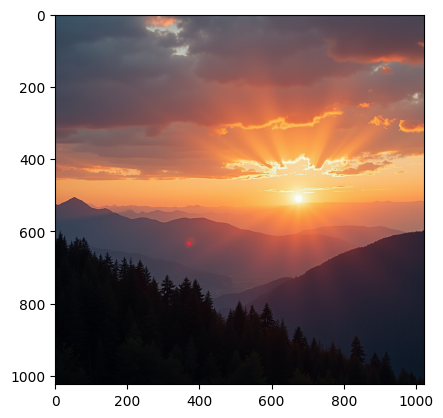

In [15]:
hf_gen = FluxGeneratorHuggingFace(pipeline=pipeline,
                                  scheduler=scheduler,
								  clip_encoder=clip_encoder,
								  clip_tokenizer=clip_tokenizer,
								  t5_encoder=t5_encoder,
								  t5_tokenizer=t5_tokenizer,
								  vae=vae,
								  model=model)

prompt = "A beautiful sunset over the mountains"

image = hf_gen.generate_image(prompt=prompt, 
                              prompt_2=prompt, 
                              height=1024, 
                              width=1024, 
                              guidance_scale=3.5,
                              num_inference_steps=50)
plt.imshow(image)

# Customized Inference

In [6]:
def get_noise(
    num_samples: int,
    height: int,
    width: int,
    device: torch.device,
    dtype: torch.dtype,
    seed: int,
):
    return torch.randn(
        num_samples,
        16,\
        2 * math.ceil(height / 16),
        2 * math.ceil(width / 16),
        device=device,
        dtype=dtype,
        generator=torch.Generator(device=device).manual_seed(seed),
    )

def time_shift(mu: float, sigma: float, t: Tensor):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)

def get_lin_function(
    x1: float = 256, y1: float = 0.5, x2: float = 4096, y2: float = 1.15
) -> Callable[[float], float]:
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return lambda x: m * x + b

def get_schedule(
    num_steps: int,
    image_seq_len: int,
    base_shift: float = 0.5,
    max_shift: float = 1.15,
    shift: bool = True,
) -> list[float]:
    # extra step for zero
    timesteps = torch.linspace(1, 0, num_steps + 1)

    # shifting the schedule to favor high timesteps for higher signal images
    if shift:
        # eastimate mu based on linear estimation between two points
        mu = get_lin_function(y1=base_shift, y2=max_shift)(image_seq_len)
        timesteps = time_shift(mu, 1.0, timesteps)

    return timesteps.tolist()

@torch.inference_mode()
def prepare(img: Tensor) -> dict[str, Tensor]:
    bs, c, h, w = img.shape
    if bs == 1 and not isinstance(prompt, str):
        bs = len(prompt)

	# Patchify the image
    img = rearrange(img, "b c (h ph) (w pw) -> b (h w) (c ph pw)", ph=2, pw=2)
    if img.shape[0] == 1 and bs > 1:
        img = repeat(img, "1 ... -> bs ...", bs=bs)

	# Calculate image ids
    img_ids = torch.zeros(h // 2, w // 2, 3)
    img_ids[..., 1] = img_ids[..., 1] + torch.arange(h // 2)[:, None]
    img_ids[..., 2] = img_ids[..., 2] + torch.arange(w // 2)[None, :]
    img_ids = repeat(img_ids, "h w c -> b (h w) c", b=bs)

    return img, img_ids.to(img.device)

In [15]:
class MyFluxGenerator:
    def __init__(self, 
                 pipeline: FluxPipeline,
                 scheduler: FlowMatchEulerDiscreteScheduler,
                 clip_encoder: CLIPTextModel,
                 clip_tokenizer: CLIPTokenizer,
                 t5_encoder: T5EncoderModel,
                 t5_tokenizer: T5TokenizerFast,
                 vae: AutoencoderKL,
                 model: FluxTransformer2DModel,
                 device: torch.device = torch.device('cuda')):
        self.pipeline = pipeline
        self.device = device
        self.scheduler = scheduler
        self.clip_encoder = clip_encoder
        self.clip_tokenizer = clip_tokenizer
        self.t5_encoder = t5_encoder
        self.t5_tokenizer = t5_tokenizer
        self.vae = vae
        self.model = model
        
    @torch.inference_mode()
    def generate_image(
        self,
        prompt: str | List[str],
        prompt_2: str | List[str],
        height: int,
        width: int,
        guidance_scale: float = 3.5,
        num_inference_steps: int = 50,
        max_sequence_length: int = 512,
        seed: int = 0,
    ):
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
            
        # 1. Check inputs. Raise error if not correct
        self.pipeline.check_inputs(prompt,
                                   prompt_2,
                                   height,
                                   width,
                                   max_sequence_length=max_sequence_length,)

        # 2. Encode the prompt
        (   prompt_embeds,
            pooled_prompt_embeds,
            text_ids,
        ) = self.pipeline.encode_prompt(
            prompt=prompt,
            prompt_2=prompt_2,
            device=self.device,
            max_sequence_length=max_sequence_length,
        )
        print(f"prompt_embeds: {prompt_embeds.shape}, pooled_prompt_embeds: {pooled_prompt_embeds.shape}, text_ids: {text_ids.shape}")
        
        # 3. Prepare latent variables and calculate timesteps
        latents = get_noise(batch_size, height, width, self.device, dtype, seed)
        
        timesteps = get_schedule( # shape: [num_inference_steps]
            num_steps=num_inference_steps,
            image_seq_len=latents.shape[-1] * latents.shape[-2] // 4,
            shift=True,  # Set True for Flux-dev, False for Flux-schnell
        )

        print(f"timesteps: {timesteps}") # same as official hf flux scheduler
        
        latents, latent_ids = prepare(latents)
        
        # 4. Denoising loop in latent space
        with self.pipeline.progress_bar(total=num_inference_steps) as progress_bar:
             for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
                t_vec = torch.full((latents.shape[0],), t_curr, dtype=latents.dtype, device=latents.device)
                guidance_vec = torch.full((latents.shape[0],), guidance_scale, device=latents.device, dtype=latents.dtype)
                print(f"time step: {t_vec[0]}")
                pred = model(
                        hidden_states=latents, # shape: [batch_size, seq_len, num_channels_latents], e.g. [1, 4096, 64] for 1024x1024
                        timestep=t_vec,        # range: [0, 1]
                        guidance=guidance_vec, # scalar guidance values for each sample in the batch
                        pooled_projections=pooled_prompt_embeds, # CLIP text embedding
                        encoder_hidden_states=prompt_embeds,     # T5 text embedding
                        txt_ids=text_ids,
                        img_ids=latent_ids,
                        joint_attention_kwargs=None,
                        return_dict=pipeline,
                    )[0]
                latents = latents + (t_prev - t_curr) * pred
                progress_bar.update()
                
		# 6. Decode the latents
        latents = self.pipeline._unpack_latents(latents, height, width, self.pipeline.vae_scale_factor)
        latents = (latents / self.pipeline.vae.config.scaling_factor) + self.pipeline.vae.config.shift_factor
        image = self.pipeline.vae.decode(latents, return_dict=False)[0]
        image = self.pipeline.image_processor.postprocess(image, output_type="pil")

        # Offload all models
        self.pipeline.maybe_free_model_hooks()
        
        return image[0] # PIL image

In [16]:
my_gen = MyFluxGenerator(pipeline=pipeline,
                         scheduler=scheduler,
						 clip_encoder=clip_encoder,
						 clip_tokenizer=clip_tokenizer,
						 t5_encoder=t5_encoder,
						 t5_tokenizer=t5_tokenizer,
						 vae=vae,
						 model=model,) 

prompt_embeds: torch.Size([1, 512, 4096]), pooled_prompt_embeds: torch.Size([1, 768]), text_ids: torch.Size([1, 512, 3])
timesteps: [1.0, 0.9935795068740845, 0.9869785904884338, 0.9801895618438721, 0.9732041954994202, 0.9660138487815857, 0.958609402179718, 0.9509812593460083, 0.9431188106536865, 0.9350114464759827, 0.9266473650932312, 0.9180141687393188, 0.9090986847877502, 0.8998868465423584, 0.8903636932373047, 0.880513072013855, 0.870317816734314, 0.8597595691680908, 0.8488184809684753, 0.837473452091217, 0.8257015943527222, 0.8134785294532776, 0.8007776737213135, 0.7875705361366272, 0.7738260626792908, 0.7595109343528748, 0.7445887327194214, 0.7290201783180237, 0.7127622961997986, 0.6957681775093079, 0.6779866814613342, 0.6593618392944336, 0.6398321986198425, 0.619330108165741, 0.5977811217308044, 0.5751029253005981, 0.55120450258255, 0.5259844064712524, 0.4993301331996918, 0.4711155593395233, 0.44119971990585327, 0.4094238877296448, 0.37560901045799255, 0.33955228328704834, 0.3010

  0%|          | 0/50 [00:00<?, ?it/s]

time step: 1.0
time step: 0.9921875
time step: 0.98828125
time step: 0.98046875
time step: 0.97265625
time step: 0.96484375
time step: 0.95703125
time step: 0.94921875
time step: 0.94140625
time step: 0.93359375
time step: 0.92578125
time step: 0.91796875
time step: 0.91015625
time step: 0.8984375
time step: 0.890625
time step: 0.87890625
time step: 0.87109375
time step: 0.859375
time step: 0.84765625
time step: 0.8359375
time step: 0.82421875
time step: 0.8125
time step: 0.80078125
time step: 0.7890625
time step: 0.7734375
time step: 0.7578125
time step: 0.74609375
time step: 0.73046875
time step: 0.7109375
time step: 0.6953125
time step: 0.6796875
time step: 0.66015625
time step: 0.640625
time step: 0.62109375
time step: 0.59765625
time step: 0.57421875
time step: 0.55078125
time step: 0.52734375
time step: 0.5
time step: 0.470703125
time step: 0.44140625
time step: 0.41015625
time step: 0.375
time step: 0.33984375
time step: 0.30078125
time step: 0.259765625
time step: 0.2158203125


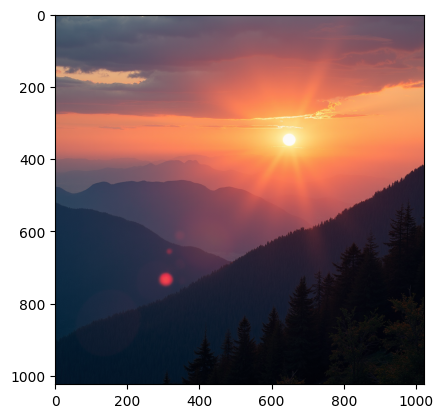

In [17]:
prompt = "A beautiful sunset over the mountains"

image = my_gen.generate_image(prompt=prompt,
                              prompt_2=prompt,
							  height=1024,
							  width=1024,
							  guidance_scale=3.5,
							  num_inference_steps=50,
                         	  seed=0) # If don't change seed, the image will be the same 

plt.imshow(image)